<a href="https://colab.research.google.com/github/veronica-araoz/veronica-araoz_clustering/blob/main/Clustering_global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este cuaderno la idea es aplicar la técnica de clustering sobre un conjunto de notas periodísticas para identificar agrupaciones temáticas en la totalidad del corpus.

Primero conectamos este notebook con mi Drive para consultar directamente el dataset sin tener que cargarlo manualmente

In [ ]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/CLUSTERING/cluster_global.xlsx'
df = pd.read_excel(file_path)

print("Archivo cargado correctamente. Filas y columnas:", df.shape)
print("Columnas:", df.columns.tolist())


Archivo cargado correctamente. Filas y columnas: (2427, 4)
Columnas: ['ID', 'Titular', 'Bajada', 'Cuerpo_texto']


Paso 1: Instalación de Librerías y Carga de Datos
Primero, instala las bibliotecas necesarias. Luego, carga tu DataFrame y prepara el texto para el análisis. Este paso combina las columnas de texto en una sola para que los modelos de embeddings puedan procesarlas de manera efectiva.

In [ ]:
# Instalación de librerías (solo necesario si aún no las tenés instaladas en Colab)
!pip install transformers sentence_transformers umap-learn
!pip install --upgrade scikit-learn openpyxl

# =====================
# Importar librerías
# =====================
import pandas as pd
import numpy as np
import re
import nltk
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# =====================
# Descargar recursos de NLTK
# =====================
try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/wordnet')
except:
    nltk.download('wordnet')

# =====================
# Cargar el DataFrame desde Drive
# =====================
file_path = '/content/drive/MyDrive/CLUSTERING/cluster_global.xlsx'
df = pd.read_excel(file_path)

# =====================
# Preparación y Conversión de Variables
# =====================
# Mantener ID como está (posiblemente int o str)
df['Titular'] = df['Titular'].fillna('').astype(str)
df['Bajada'] = df['Bajada'].fillna('').astype(str)
df['Cuerpo_texto'] = df['Cuerpo_texto'].fillna('').astype(str)

# Concatenar columnas de texto en una sola
df['texto_completo'] = df[['Titular', 'Bajada', 'Cuerpo_texto']].agg(' '.join, axis=1)

print("✅ Paso 1 completado: Librerías instaladas y datos cargados.")
print("Columnas de tu DataFrame:", df.columns.tolist())
print("\nEjemplo de texto combinado:\n", df['texto_completo'].iloc[0][:500])


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Paso 1 completado: Librerías instaladas y datos cargados.
Columnas de tu DataFrame: ['ID', 'Titular', 'Bajada', 'Cuerpo_texto', 'texto_completo']

Ejemplo de texto combinado:
 Con 38 casos, la provincia registró el número más alto de femicidios en una década Del total de los casos, 32 fueron cometidos por personas del círculo íntimo de la víctima. De las mujeres asesinadas, 22 no superaban los 34 años. La cifra surge del relevamiento de violencia de género que lleva adelante la concejal Norma López. La provincia de Santa Fe registró el número más alto de femicidios en diez años. En 2017, se rgistraron 38 casos, 16 en el depaartamento Rosario. De la mujeres asesinadas,


Paso 2: Generación de Embeddings y Reducción de Dimensionalidad (UMAP) Este paso trabaja con los datos del DataFrame completo, generando una única matriz de embeddings para todas las notas. Luego, esta matriz se utilizará para filtrar por medio en el siguiente paso.

Sobre SentenceTransformer: Entiende la Semántica: El modelo no solo sabe qué es una palabra, sino que también comprende su relación con otras palabras. Por ejemplo, el modelo ya aprendió que "marcha" y "protesta" son muy similares en significado, mientras que "marcha" y "computadora" son muy diferentes. Lo hace sin que tú tengas que enseñárselo.

Maneja la Morfología: Al estar pre-entrenado, el modelo ya sabe que palabras como "marchó," "marchaban" y "marcha" son variaciones de la misma raíz, "marchar." Esta es la razón por la que no necesitas hacer explícitamente la lematización; el modelo ya ha aprendido a manejar estas variaciones.

In [ ]:
# =====================
# Generación de embeddings
# =====================

# Modelo preentrenado multilingüe (funciona bien en español)
model_name = 'distiluse-base-multilingual-cased-v1'
model = SentenceTransformer(model_name)

# Generar embeddings para cada nota del corpus
embeddings = model.encode(df['texto_completo'].tolist(), show_progress_bar=True)

print("✅ Embeddings generados.")
print("Forma de la matriz de embeddings:", embeddings.shape)  # (n_notas, 512)

# =====================
# Reducción de dimensionalidad con UMAP
# =====================
# n_neighbors: equilibrio entre estructura local/global
# min_dist: controla dispersión de los puntos
# n_components: cuántas dimensiones queremos conservar
reducer = UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=5,
    metric='cosine',
    random_state=42
)

reduced_embeddings = reducer.fit_transform(embeddings)

print("✅ Dimensionalidad reducida con UMAP.")
print("Forma de la matriz reducida:", reduced_embeddings.shape)  # (n_notas, 5)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/76 [00:00<?, ?it/s]

✅ Embeddings generados.
Forma de la matriz de embeddings: (2427, 512)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Dimensionalidad reducida con UMAP.
Forma de la matriz reducida: (2427, 5)


Paso 3:  Encontrar el k óptimo (Análisis y Decisión)
Este código evalúa el rango de clústeres y muestra los resultados de la silueta y el codo.


--- Método de la Silueta ---
Silueta para k=2: 0.7556
Silueta para k=3: 0.4815
Silueta para k=4: 0.3089
Silueta para k=5: 0.3176
Silueta para k=6: 0.3185
Silueta para k=7: 0.3218
Silueta para k=8: 0.3338
Silueta para k=9: 0.3435

Número óptimo de clústeres (Silueta): 2

--- Método del Codo ---
Inercia para k=2: 5086.48
Inercia para k=3: 4179.11
Inercia para k=4: 3538.74
Inercia para k=5: 3004.88
Inercia para k=6: 2613.36
Inercia para k=7: 2312.89
Inercia para k=8: 2134.53
Inercia para k=9: 1965.66


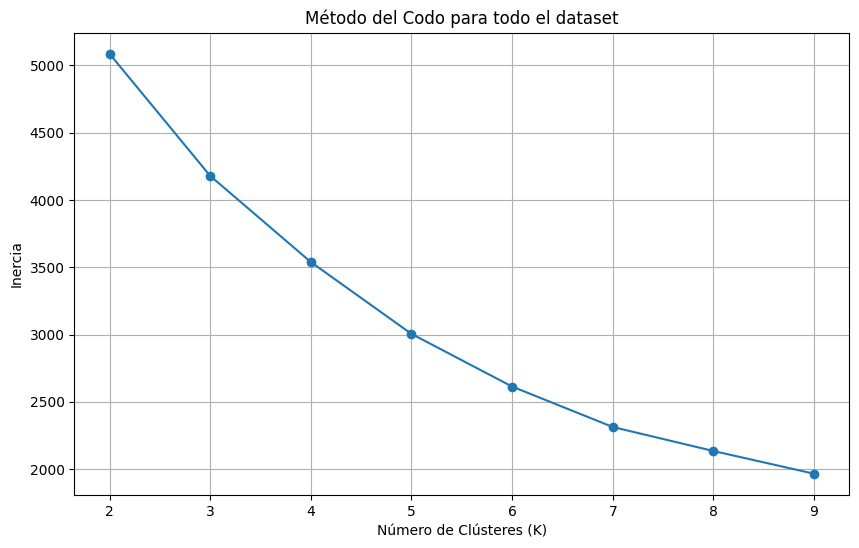

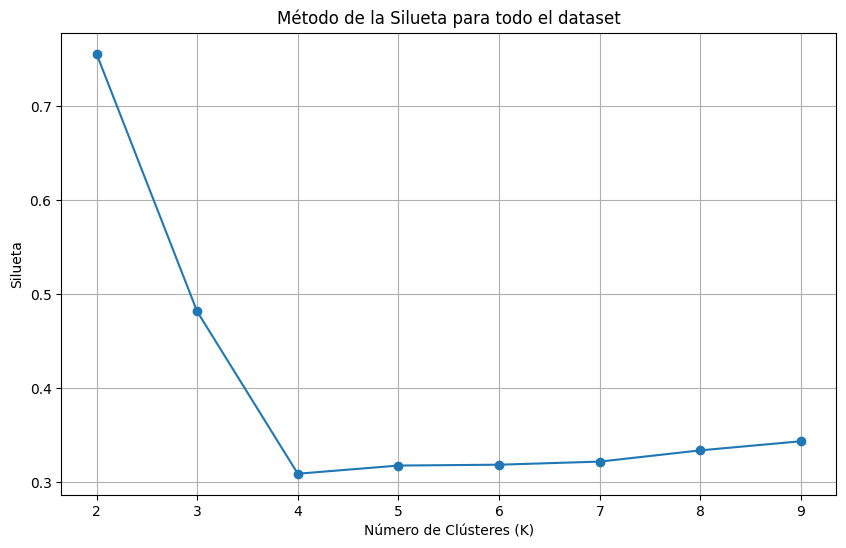

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# =====================
# Análisis del k óptimo
# =====================
# Definimos el rango de k a evaluar
k_range = range(2, 10)

# 1. Método de la Silueta
silhouettes = []
print("\n--- Método de la Silueta ---")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(reduced_embeddings)
    score = silhouette_score(reduced_embeddings, labels)
    silhouettes.append(score)
    print(f"Silueta para k={k}: {score:.4f}")

# Mejor k según la silueta
best_k_silhouette = k_range[np.argmax(silhouettes)]
print(f"\nNúmero óptimo de clústeres (Silueta): {best_k_silhouette}")

# 2. Método del Codo
inercia = []
print("\n--- Método del Codo ---")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(reduced_embeddings)
    inercia.append(kmeans.inertia_)
    print(f"Inercia para k={k}: {kmeans.inertia_:.2f}")

# Gráfico del Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inercia, marker='o', linestyle='-')
plt.title('Método del Codo para todo el dataset')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Inercia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Gráfico del Método de la Silueta
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouettes, marker='o', linestyle='-')
plt.title('Método de la Silueta para todo el dataset')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Silueta')
plt.xticks(k_range)
plt.grid(True)
plt.show()


Interpretación sobre la cantidad de clusters:

**La silueta** mide qué tan bien separados y cohesionados están los clusters: Valores cercanos a 1 → clusters bien definidos y separados. Valores cercanos a 0 → clusters superpuestos o poco claros. Valores negativos → mala asignación de clusters.

--> **La silueta máxima es 0.7556 con k=2**, lo que indica que dividir todo el material en 2 clusters genera la separación más clara y cohesionada.

La inercia mide la suma de distancias al centroide dentro de cada cluster: La idea es buscar el “codo”, donde agregar más clusters ya no reduce significativamente la inercia.La inercia baja continuamente al aumentar k, pero el mayor cambio relativo se da al pasar de k=2 a k=3 (una caída de ~907 puntos). Después de k=3-4, la reducción se hace más gradual.
Esto indica que **2-3 clusters podrían ser un buen balance** entre simplicidad y explicación del dataset.

Paso 4: Aplicar K-Means con el k elegido (Ejecución)
Una vez que has analizado los resultados del bloque anterior, puedes elegir el valor de k_final que más te convenga y ejecutar este bloque.

In [ ]:
from sklearn.cluster import KMeans

# =====================
# Definir K final
# =====================
k_final = 2  # o 3 si querés explorar más detalle

# =====================
# Aplicar K-Means a todo el corpus
# =====================
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df['cluster_label'] = kmeans_final.fit_predict(reduced_embeddings)

# Mostrar conteo de notas por cluster
print(f"\nConteo de notas por clúster con K={k_final}:")
print(df['cluster_label'].value_counts().sort_index())

# =====================
# Guardar resultados en Excel
# =====================
output_path = '/content/clusters_global.xlsx'
df.to_excel(output_path, index=False)
print(f"✅ Resultados guardados en: {output_path}")



Conteo de notas por clúster con K=2:
cluster_label
0    1017
1    1410
Name: count, dtype: int64
✅ Resultados guardados en: /content/clusters_global.xlsx


Visualizaciones:

gráfico de dispersión 2D

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


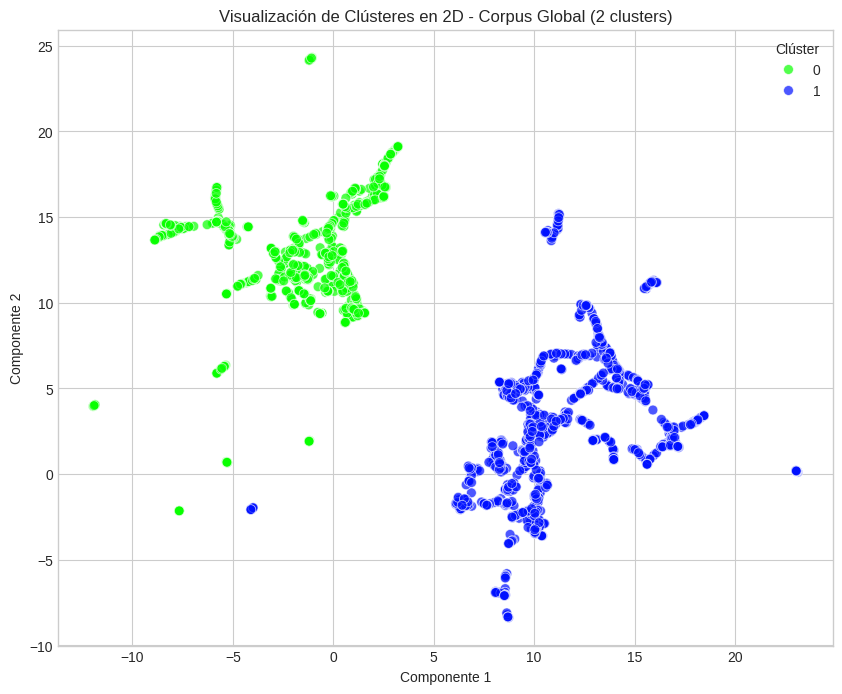

✅ Gráfico guardado en: /content/clusters_global_2D.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# =====================
# Visualización en 2D con UMAP (flexible para cualquier número de clusters)
# =====================
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
import numpy as np

# Configuración de estilo
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

# Detectar cuántos clusters hay en df['cluster_label']
clusters_unicos = sorted(df['cluster_label'].unique())
n_clusters = len(clusters_unicos)

# Generar colores automáticamente
palette = sns.color_palette("hsv", n_clusters)
colores_clusters = {cluster: palette[i] for i, cluster in enumerate(clusters_unicos)}

# Reducir embeddings a 2D
reducer_2d = UMAP(n_components=2, random_state=42, metric='cosine')
embeddings_2d = reducer_2d.fit_transform(reduced_embeddings)

# Gráfico de dispersión
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    hue=df['cluster_label'],
    palette=colores_clusters,
    s=50,
    alpha=0.7
)
plt.title(f'Visualización de Clústeres en 2D - Corpus Global ({n_clusters} clusters)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Clúster', loc='best')
plt.show()

# Guardar gráfico opcionalmente
output_path_fig = '/content/clusters_global_2D.png'
plt.savefig(output_path_fig, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico guardado en: {output_path_fig}")



--- Generando Nubes de Palabras para el corpus global ---


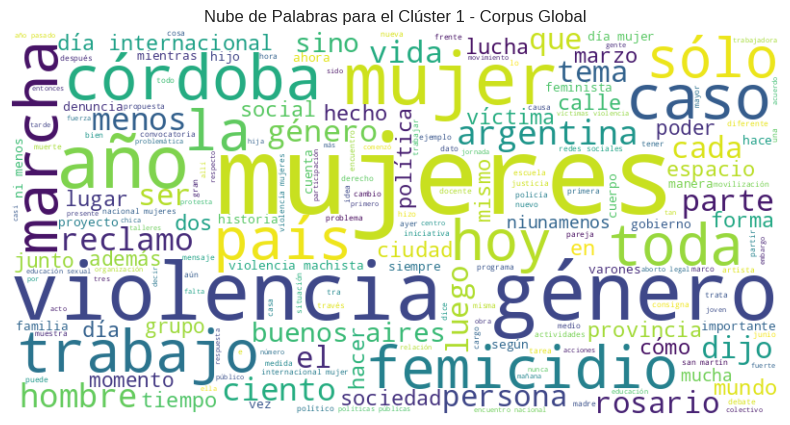

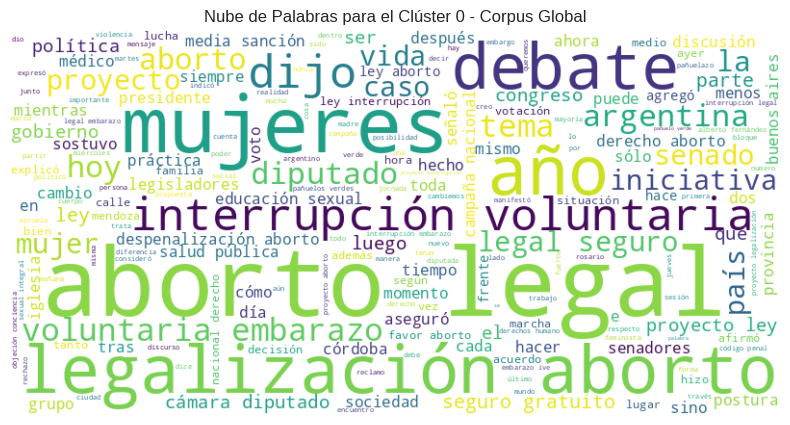

In [ ]:
!pip install wordcloud

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
import re

# Descargar recursos de NLTK
try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords')

# Lista de palabras irrelevantes adicionales
palabras_irrelevantes = [
    'noticias', 'relacionadas', 'ver', 'más', 'además', 'así',
    'comentarios', 'nan', 'aunque', 'solo', 'uno', 'aun'
]

print("\n--- Generando Nubes de Palabras para el corpus global ---")

# Agrupar textos por cluster
cluster_texts = defaultdict(list)
for _, row in df.iterrows():
    cluster_texts[row['cluster_label']].append(row['texto_completo'])

# Obtener stopwords en español y añadir palabras irrelevantes
stop_words = set(stopwords.words('spanish') + palabras_irrelevantes)

for cluster_id, texts in cluster_texts.items():
    all_text = ' '.join(texts)

    # Preprocesamiento del texto
    all_text = all_text.lower()
    all_text = re.sub(r'\d+', '', all_text)
    all_text = ' '.join([word for word in all_text.split() if word not in stop_words and len(word) > 2])

    # Generar nube de palabras
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(all_text)

    # Mostrar gráfico
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras para el Clúster {cluster_id} - Corpus Global')
    plt.show()


In [ ]:
import pandas as pd
import re
from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords

# =====================
# Preparar stopwords
# =====================
try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords')

palabras_irrelevantes = [
    'noticias', 'relacionadas', 'ver', 'más', 'además', 'así',
    'comentarios', 'nan', 'aunque', 'solo', 'sólo', 'ciento', 'dos', 'san', 'nan',
    'ser', 'años', 'año', 'cada', 'muchos', 'uno', 'aun'
]
stop_words = set(stopwords.words('spanish') + palabras_irrelevantes)

# =====================
# Agrupar textos por cluster
# =====================
cluster_texts = defaultdict(list)
for _, row in df.iterrows():
    cluster_texts[row['cluster_label']].append(row['texto_completo'])

# =====================
# Función para limpiar y tokenizar
# =====================
def limpiar_tokenizar(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar números
    texto = re.sub(r'\d+', '', texto)
    # Solo letras (a-z, áéíóúñ) y palabras de al menos 3 letras
    palabras = re.findall(r'\b[a-záéíóúñ]{3,}\b', texto)
    # Eliminar stopwords
    palabras = [w for w in palabras if w not in stop_words]
    return palabras

# =====================
# 1️⃣ Tabla de palabras clave (10 más frecuentes)
# =====================
palabras_clave = {}
n_palabras = 10

for cluster_id, texts in cluster_texts.items():
    all_words = []
    for txt in texts:
        all_words.extend(limpiar_tokenizar(txt))
    freq = Counter(all_words)
    palabras_clave[cluster_id] = [w for w, _ in freq.most_common(n_palabras)]

df_palabras_clave = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in palabras_clave.items()]))
print("\n=== Palabras clave por cluster (10 más frecuentes) ===")
display(df_palabras_clave)

# =====================
# 2️⃣ Tabla de palabras distintivas por cluster (Top N por frecuencia)
# =====================
top_n_distintivas = 10  # número de palabras distintivas más relevantes a mostrar
palabras_distintivas = {}

# Crear sets de palabras limpias por cluster
cluster_sets = {}
cluster_freqs = {}
for cluster_id, texts in cluster_texts.items():
    all_words = []
    for txt in texts:
        all_words.extend(limpiar_tokenizar(txt))
    cluster_sets[cluster_id] = set(all_words)
    cluster_freqs[cluster_id] = Counter(all_words)

# Identificar palabras exclusivas y tomar Top N por frecuencia
for cluster_id, words in cluster_sets.items():
    otras = set().union(*(s for cid, s in cluster_sets.items() if cid != cluster_id))
    exclusivas = words - otras
    # Filtrar las palabras exclusivas por frecuencia y tomar top N
    top_exclusivas = [w for w, _ in cluster_freqs[cluster_id].most_common() if w in exclusivas][:top_n_distintivas]
    palabras_distintivas[cluster_id] = top_exclusivas

df_palabras_distintivas = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in palabras_distintivas.items()]))
print("\n=== Palabras distintivas por cluster (Top N más relevantes) ===")
display(df_palabras_distintivas)



=== Palabras clave por cluster (10 más frecuentes) ===


,1,0
0,mujeres,aborto
1,violencia,proyecto
2,género,mujeres
3,mujer,legal
4,córdoba,ley
5,día,salud
6,menos,embarazo
7,marcha,favor
8,nacional,debate
9,femicidios,vida



=== Palabras distintivas por cluster (Top N más relevantes) ===


,1,0
0,doméstica,perotti
1,necochea,rubinstein
2,colección,pichetto
3,topless,feto
4,sársfield,verasay
5,juárez,gestacional
6,besazo,debatirá
7,tetas,crexell
8,estación,sacerdotes
9,ocupan,legaliza
